In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,estimate
from eden.graph import Vectorizer
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [43]:
def fit_sample(graphs):
    graphs, graphs_ = tee(graphs)
    sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],
                              min_cip_count=2, min_interface_count=2,
                              vectorizer=Vectorizer(5))
    
    sampler.fit(graphs, nu=0.3, n_jobs=-1)

    print('graph grammar stats:')
    interface_counts, core_counts, cip_counts = sampler.grammar().size()
    print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))
    graphs = sampler.sample(graphs_,
                            n_steps=5, n_samples=4,
                            target_orig_cip=True,
                            probabilistic_core_choice=False,
                            score_core_choice= True,
                            max_core_size_diff=0,
                            improving_threshold=0.3, accept_static_penalty=0,
                            generator_mode=True,
                            n_jobs=-1,burnin=1,select_cip_max_tries=200,keep_duplicates=True)
    return graphs

In [44]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        if pos_size == 0 or neg_size == 0:
            print "-"*80
            print 'working on %s'%(desc)
            print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
            print 'WARNING: empty dataset'
            predictive_performances.append(0)            
        else:
            start=time()
            print "-"*80
            print 'working on %s'%(desc)
            print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances

In [45]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random.seed(int(313379*percentage+repetition))
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            print('Positive')
            sampled_pos = fit_sample(pos_)
            print('Negative')
            sampled_neg = fit_sample(neg_)

            #evaluate the predictive performance on held out test set
            start=time()
            print "="*80
            print 'repetition: %d/%d'%(repetition+1, n_repetitions)
            print "training percentage:"+str(percentage)
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            print 'Time elapsed: %.1f sec'%((time()-start))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [49]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    ws = 0.02
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.title(dataset+'\n',fontsize=17)
    plt.legend(loc='lower right',fontsize=16)
    plt.ylabel('ROC AUC',fontsize=16)
    plt.xlabel('Dataset size (fraction)',fontsize=16)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

Working with dataset: HCT_15_t
Positive
graph grammar stats:
#interfaces: 26   #cores: 36   #core-interface-pairs: 104
Negative
graph grammar stats:
#interfaces: 24   #cores: 33   #core-interface-pairs: 80
repetition: 1/3
training percentage:0.05
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 21 #neg: 21
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.55      0.72      0.62       180
          1       0.60      0.42      0.49       180

avg / total       0.57      0.57      0.56       360

APR: 0.561
ROC: 0.609
Cross-validated estimate
            accuracy: 0.656 +- 0.032
           precision: 0.665 +- 0.046
              recall: 0.644 +- 0.105
                  f1: 0.648 +- 0.049
   average_precision: 0.

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 572


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.52      0.80      0.63       180
          1       0.56      0.25      0.34       180

avg / total       0.54      0.53      0.49       360

APR: 0.533
ROC: 0.580
Cross-validated estimate
            accuracy: 0.633 +- 0.053
           precision: 0.655 +- 0.067
              recall: 0.589 +- 0.110
                  f1: 0.613 +- 0.062
   average_precision: 0.731 +- 0.069
             roc_auc: 0.727 +- 0.067
elapsed: 6.4 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 84 #neg: 82
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Es

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 437


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.53      0.79      0.64       180
          1       0.60      0.31      0.40       180

avg / total       0.57      0.55      0.52       360

APR: 0.582
ROC: 0.621
Cross-validated estimate
            accuracy: 0.642 +- 0.054
           precision: 0.655 +- 0.067
              recall: 0.628 +- 0.119
                  f1: 0.633 +- 0.064
   average_precision: 0.736 +- 0.051
             roc_auc: 0.720 +- 0.058
elapsed: 6.2 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 84 #neg: 84
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Es

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 572


--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 250 #neg: 252


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 135, in doRollover
    os.rename(sfn, dfn)
    os.remove(dfn)
OSError: [Errno 2] No such file or directory
OSError: [Errno 2] No such file or directory: '/Users/costa/Desktop/BTSync/Projects/graphlearn/example/HCT_15_t_predictive_performance_of_samples.log.10'
Logged from file graphlearn.py, line 572
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.62      0.74      0.68       180
          1       0.68      0.55      0.61       180

avg / total       0.65      0.64      0.64       360

APR: 0.700
ROC: 0.703
Cross-validated estimate
            accuracy: 0.625 +- 0.044
           precision: 0.639 +- 0.052
              recall: 0.594 +- 0.062
                  f1: 0.613 +- 0.039
   average_precision: 0.725 +- 0.053
             roc_auc: 0.715 +- 0.056
elapsed: 9.8 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 334 #neg: 336
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test 

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 135, in doRollover
    os.remove(dfn)
OSError: [Errno 2] No such file or directory: '/Users/costa/Desktop/BTSync/Projects/graphlearn/example/HCT_15_t_predictive_performance_of_samples.log.10'
Logged from file graphlearn.py, line 572


--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 502 #neg: 504
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.67      0.73      0.70       180
          1       0.70      0.63      0.67       180

avg / total       0.69      0.68      0.68       360

APR: 0.746
ROC: 0.755
Cross-validated estimate
            accuracy: 0.619 +- 0.038
           precision: 0.629 +- 0.045
              recall: 0.589 +- 0.118
                  f1: 0.602 +- 0.068
   average_precision: 0.724 +- 0.061
             roc_auc: 0.710 +- 0.053
elapsed: 16.1 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 670 #neg: 672
Test set
Instances: 360 ; Featu

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 572


--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 502 #neg: 504
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.66      0.72      0.69       180
          1       0.69      0.63      0.66       180

avg / total       0.67      0.67      0.67       360

APR: 0.716
ROC: 0.728
Cross-validated estimate
            accuracy: 0.619 +- 0.050
           precision: 0.620 +- 0.045
              recall: 0.622 +- 0.103
                  f1: 0.617 +- 0.061
   average_precision: 0.725 +- 0.050
             roc_auc: 0.712 +- 0.047
elapsed: 15.7 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 670 #neg: 672
Test set
Instances: 360 ; Featu

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 135, in doRollover
    os.remove(dfn)
OSError: [Errno 2] No such file or directory: '/Users/costa/Desktop/BTSync/Projects/graphlearn/example/HCT_15_t_predictive_performance_of_samples.log.10'
Logged from file graphlearn.py, line 224


--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 1008 #neg: 1006
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.69      0.67      0.68       180
          1       0.68      0.69      0.69       180

avg / total       0.68      0.68      0.68       360

APR: 0.742
ROC: 0.748
Cross-validated estimate
            accuracy: 0.639 +- 0.041
           precision: 0.651 +- 0.065
              recall: 0.628 +- 0.094
                  f1: 0.633 +- 0.045
   average_precision: 0.727 +- 0.067
             roc_auc: 0.724 +- 0.063
elapsed: 25.8 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 1344 #neg: 1342
Test set
Instances: 360 ; F

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 572


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.66      0.61      0.63       180
          1       0.64      0.69      0.66       180

avg / total       0.65      0.65      0.65       360

APR: 0.749
ROC: 0.742
Cross-validated estimate
            accuracy: 0.633 +- 0.048
           precision: 0.648 +- 0.062
              recall: 0.617 +- 0.138
                  f1: 0.621 +- 0.065
   average_precision: 0.731 +- 0.065
             roc_auc: 0.718 +- 0.068
elapsed: 25.9 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 1344 #neg: 1342
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Te

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.66      0.68      0.67       180
          1       0.67      0.65      0.66       180

avg / total       0.66      0.66      0.66       360

APR: 0.736
ROC: 0.741
Cross-validated estimate
            accuracy: 0.628 +- 0.068
           precision: 0.637 +- 0.072
              recall: 0.606 +- 0.122
                  f1: 0.615 +- 0.081
   average_precision: 0.726 +- 0.070
             roc_auc: 0.716 +- 0.071
elapsed: 26.0 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 1344 #neg: 1342
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Te

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.67      0.66      0.67       180
          1       0.67      0.68      0.67       180

avg / total       0.67      0.67      0.67       360

APR: 0.730
ROC: 0.740
Cross-validated estimate
            accuracy: 0.631 +- 0.029
           precision: 0.640 +- 0.042
              recall: 0.617 +- 0.067
                  f1: 0.624 +- 0.029
   average_precision: 0.724 +- 0.069
             roc_auc: 0.725 +- 0.051
elapsed: 28.2 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 1596 #neg: 1594
Test set
Instances: 360 ; Features: 1048577 with an avg of 408 features per instance
--------------------------------------------------------------------------------
Te

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.59      0.82      0.68       180
          1       0.70      0.42      0.53       180

avg / total       0.64      0.62      0.60       360

APR: 0.670
ROC: 0.679
Cross-validated estimate
            accuracy: 0.661 +- 0.031
           precision: 0.649 +- 0.037
              recall: 0.717 +- 0.057
                  f1: 0.679 +- 0.025
   average_precision: 0.709 +- 0.086
             roc_auc: 0.723 +- 0.055
elapsed: 9.9 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 336 #neg: 336
Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test 

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.63      0.81      0.71       180
          1       0.74      0.53      0.62       180

avg / total       0.69      0.67      0.67       360

APR: 0.707
ROC: 0.720
Cross-validated estimate
            accuracy: 0.664 +- 0.049
           precision: 0.661 +- 0.063
              recall: 0.711 +- 0.067
                  f1: 0.680 +- 0.026
   average_precision: 0.724 +- 0.084
             roc_auc: 0.717 +- 0.054
elapsed: 16.5 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 672 #neg: 672
Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 224


Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.62      0.74      0.68       180
          1       0.68      0.55      0.61       180

avg / total       0.65      0.64      0.64       360

APR: 0.686
ROC: 0.697
Cross-validated estimate
            accuracy: 0.658 +- 0.049
           precision: 0.658 +- 0.060
              recall: 0.689 +- 0.054
                  f1: 0.669 +- 0.030
   average_precision: 0.737 +- 0.077
             roc_auc: 0.723 +- 0.060
elapsed: 15.9 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 672 #neg: 672
Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test

Traceback (most recent call last):
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 77, in emit
    self.doRollover()
  File "/Users/costa/anaconda/lib/python2.7/logging/handlers.py", line 136, in doRollover
    os.rename(sfn, dfn)
OSError: [Errno 2] No such file or directory
Logged from file graphlearn.py, line 572


--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 504 #neg: 504
Test set
Instances: 360 ; Features: 1048577 with an avg of 392 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.63      0.82      0.71       180
          1       0.74      0.52      0.61       180

avg / total       0.69      0.67      0.66       360

APR: 0.694
ROC: 0.712
Cross-validated estimate
            accuracy: 0.681 +- 0.046
           precision: 0.689 +- 0.066
              recall: 0.683 +- 0.060
                  f1: 0.682 +- 0.034
   average_precision: 0.750 +- 0.079
             roc_auc: 0.738 +- 0.059
elapsed: 16.3 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 672 #neg: 672
Test set
Instances: 360 ; Featu

KeyboardInterrupt: 

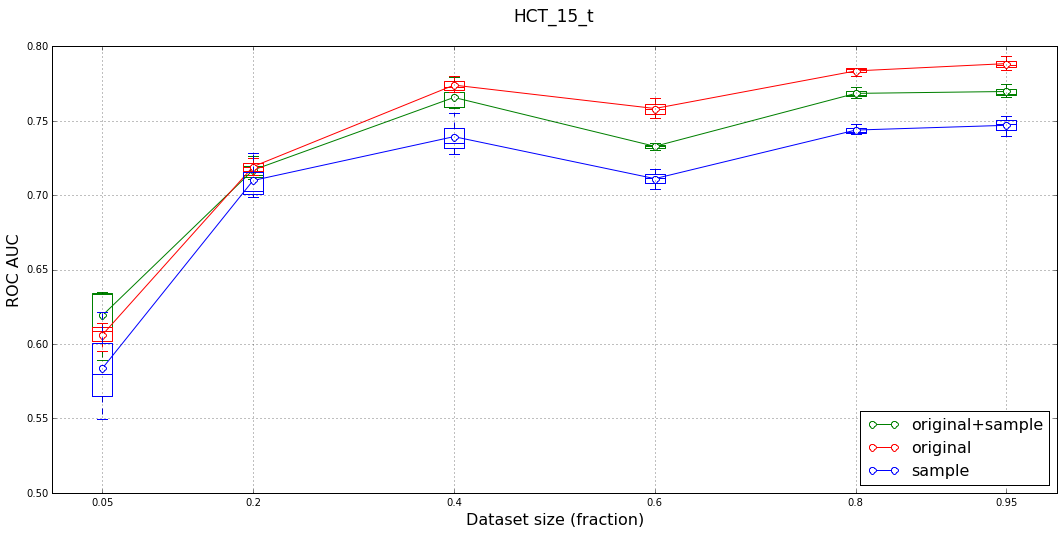

In [51]:
%%time
#experiment

dataset_names = !cat NCI60/names

for dataset in dataset_names:
    print 'Working with dataset: %s' % dataset 
    pos_dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
    neg_dataset_fname = 'NCI60/' + dataset + '_orig_neg.gspan'
    #pos_dataset_fname = 'bursi.pos.gspan'
    #neg_dataset_fname = 'bursi.neg.gspan'
    configure_logging(logging.getLogger(),verbosity=1, filename='%s_predictive_performance_of_samples.log'%dataset)


    percentages=[.05,.2,.4,.6,.8,.95]

    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,neg_dataset_fname,
                                  size=600,
                                  percentages=percentages,
                                  n_repetitions=3,
                                  train_test_split=0.7)
    plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions)


.

**TO DO:**
- use a progressive random seed for each trial
- log everything also print 
- save results as text vector files
- do the plots from the reloaded result files